# **Finding the Lane Lines**

This book explores creating a sliding window algorithm to fit a polyline to a thresholded image.

## **Imports**

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.calibration import *
from src.transform import *

In [7]:
calibration = Calibration('camera_cal/', (9, 6))
transform = Transform()

## **Motivation**

The binary threshold image that was created in the last book defined the lane lines well. If we wanted to, we could change the white pixels to red and mask it onto the originak image and we would have the lines drawn on the image.

The problem is the same as the one we tried to work with in the tresholding book, the road and camera conditions have a great degree of variation. Not every image is clear with a lot of contrast between the road and markers. In some cases the lane markers might not exist for a small portion of the road at all. The perspective transformation also has distortion near the top of the image which alters the colour properties. This means that not every pixel of the line will be detected, resulting in a choppy looking line. 

The best thing to do here is to use the information we _are_ able to extrapolate from thresholding and estimate a line to give us a good approximation of the lane markers.

## **Setup**

Let's take a look at an image where a white lane marker is missing on the right line.

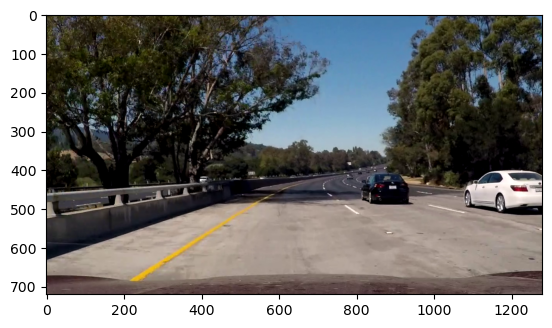

In [2]:
orig_img = cv2.imread('output_media/debug/problem_frames/pf_11.png')
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

plt.imshow(orig_img)

First, let's remove camera distortion and transform it to top-view.

Text(0.5, 1.0, 'Top-View')

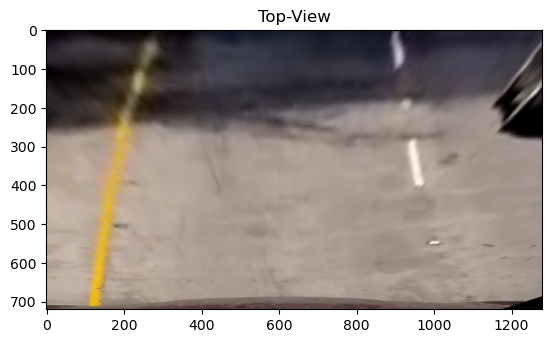

In [9]:
cal_img = calibration.undistort(orig_img)
bev_img = transform.orig_to_bev(cal_img)

plt.imshow(bev_img)
plt.title('Top-View')

Now lets apply thresholding and see what we can extract from it.

Text(0.5, 1.0, 'Binary Threshold')

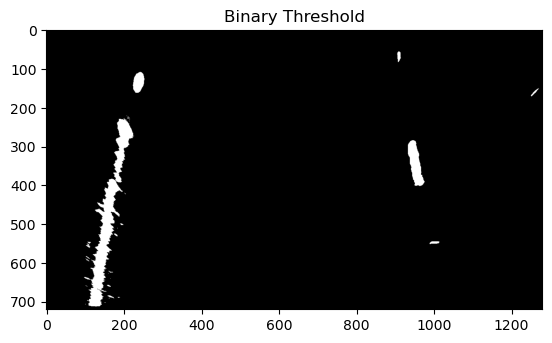

In [36]:
# Get colour spaces
hls = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(bev_img, cv2.COLOR_RGB2HSV)

# Define threshold range bounds
lightness_lower = np.array([195])
lightness_upper = np.array([255])
yellow_lower = np.array([int(40 / 2), int(0.00 * 255), int(0.50 * 255)])
yellow_upper = np.array([int(50 / 2), int(1.00 * 255), int(1.00* 255)])

# Threshold colour spaces
lightness = cv2.inRange(hls[:, :, 1], lightness_lower, lightness_upper)
yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)

# Combine thresholds
output = lightness | yellow

# Plot image
plt.imshow(output, cmap='gray')
plt.title('Binary Threshold')

There is a bit of noise in the yellow line and the top marker for the white line isn't fully captured. Not a great situation, but we have enough information where we can estimate a line that fits well.

## **Sliding Window Alogrithm**



## **Historgram**

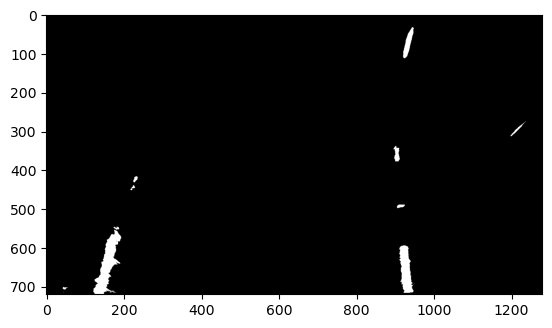

In [2]:
img = cv2.imread('book_images/threshold.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

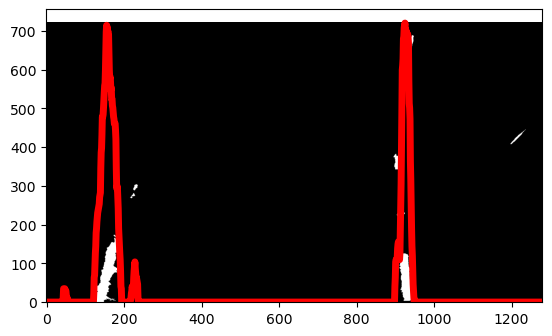

In [3]:
hist = np.sum(img[img.shape[0] // 2:, :], axis=0)

hist_scaled = hist.astype('float32')
hist_scaled *= (img.shape[0]) / hist.max()

implot = plt.imshow(np.flipud(img), origin='lower', cmap='gray')
plt.plot(hist_scaled, linewidth=5, color='red')
plt.show()

In [4]:
def find_pixels(center, margin, window_height, non_zero_x, non_zero_y):
    
    # Define top-left and bottom-right x and y coords for window boundry
    top_left = (center[0] - margin, center[1] - (window_height // 2))
    bottom_right = (center[0] + margin, center[1] + window_height // 2)
    
    # Create conditions for array indexing
    cond_x = (non_zero_x >= top_left[0]) & (non_zero_x <= bottom_right[0])
    cond_y = (non_zero_y >= top_left[1]) & (non_zero_y <= bottom_right[1])

    # Index non-zero array to only take pixels within the window boundries
    targets_x = non_zero_x[cond_x & cond_y]
    targets_y = non_zero_y[cond_x & cond_y]

    # print(top_left, bottom_right)
    # print(len(targets_x), len(targets_y))

    return targets_x, targets_y

In [5]:
# Create historgram
hist = np.sum(img[img.shape[0] // 2:, :], axis=0)

# Define midpoint of historgram
midpoint = int(hist.shape[0] / 2)

# Define base location of left and right lines based on the peak
# of the histograms to the left and right of the midpoint
left_x_base = np.argmax(hist[:midpoint])
right_x_base = np.argmax(hist[midpoint:]) + midpoint

# Define the number of sliding windows and window height
n_windows = 9
window_height = int(img.shape[0] // n_windows)

# Define margin for window width
margin = 100

# Create pointers for lane center x locations
left_x_curr = left_x_base
right_x_curr = right_x_base

# Create pointer for y locations of center of first window
y_curr = img.shape[0] - window_height // 2

# Create empty lists to store lane line pixel locations
left_x, left_y, right_x, right_y = [], [], [], []

# Get x and y poisitions of all non-zero pixels in image
non_zero = img.nonzero()
non_zero_x = np.array(non_zero[1])
non_zero_y = np.array(non_zero[0])

# Define minimum number of pixels detected to shift window
min_pixels = 50



# Start sliding window
for _ in range(n_windows):
    # Define center coords of left and right windows
    print(left_x_curr, right_x_curr, y_curr)
    center_left = (left_x_curr, y_curr)
    center_right = (right_x_curr, y_curr)

    # Get x and y coords of pixels that fall within the window
    left_window_x, left_window_y = find_pixels(center_left, margin, window_height, non_zero_x, non_zero_y)
    right_window_x, right_window_y = find_pixels(center_right, margin, window_height, non_zero_x, non_zero_y)

    # Add pixels detected in window to master lists
    left_x.extend(left_window_x)
    left_y.extend(left_window_y)
    right_x.extend(right_window_x)
    right_y.extend(right_window_y)

    # Update pointers
    if len(left_window_x) >= min_pixels:
        left_x_curr = np.int32(np.mean(left_window_x))
    if len(right_window_x) >= min_pixels:
        right_x_curr = np.int32(np.mean(right_window_x))
    y_curr -= window_height

155 925 680
148 929 600
168 924 520
180 914 440
227 914 360
227 904 280
227 904 200
227 904 120
227 929 40


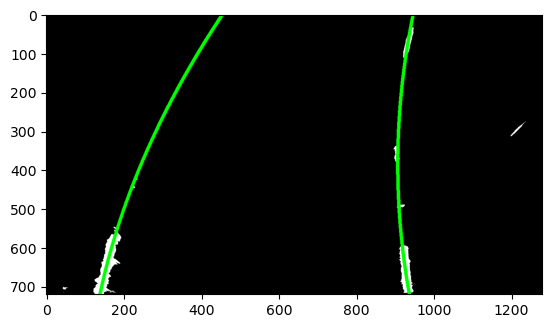

In [6]:
out_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# out_img = np.zeros((img.shape[0], img.shape[1], 3))

left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

draw_x = np.linspace(0, img.shape[1], img.shape[1])

draw_y_left = np.polyval(left_fit, draw_x)
draw_y_right = np.polyval(right_fit, draw_x)

draw_points_left = (np.asarray([draw_y_left, draw_x]).T).astype(np.int32)
draw_points_right = (np.asarray([draw_y_right, draw_x]).T).astype(np.int32)

draw = cv2.polylines(out_img, [draw_points_left], False, (0, 255, 0), thickness=8)
draw = cv2.polylines(out_img, [draw_points_right], False, (0, 255, 0), thickness=8)
draw = draw.astype(np.int32)
plt.imshow(draw)

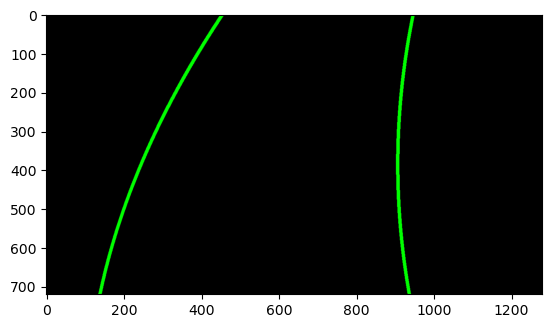

In [7]:
out_img = np.zeros((img.shape[0], img.shape[1], 3))

draw = cv2.polylines(out_img, [draw_points_left], False, (0, 255, 0), thickness=8)
draw = cv2.polylines(out_img, [draw_points_right], False, (0, 255, 0), thickness=8)
# draw = draw.astype(np.int32)

cv2.imwrite('book_images/lines.png', draw)
plt.imshow(out_img.astype(np.int32))